[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1i1EzZ0cexXd6-yidn-LQn1MMiPWJTUnL)


# DIAGNÓSTICO DE IMÁGENES HISTOLÓGICAS DE PRÓSTATA UTILIZANDO MÉTODOS DE EXPLICABILIDAD EN DEEP LEARNING

### Cuaderno asociado al Trabajo Final de Grado de Pedro Gallego López.

La finalidad de este cuaderno es de ofrecer un medio para probar las técnicas de explicabilidad CAM, Grad-CAM, Grad-CAM++ y Smooth Grad-CAM++ implementadas desde cero sobre las redes VGG16, RESNET18, MOBILENETv2 y EFFICIENTNETB0. La totalidad del código está en Python.
Requerimientos:
- Matplotlib
- Numpy
- OpenCV
- Math
- abc
- json
- Pytorch
- Scikit Learn

El cuaderno va a aportar funcionalidades básicas como la carga de datos y de modelos. El proceso de elección del mejor umbral y la ejecución de ejemplos para ver los mapas de activación.

### Requisitos previos

Para que funcione el siguiente código es necesario crear un acceso directo del  drive donde están todos los archivos necesarios: [https://drive.google.com/drive/folders/1xPpi4JEaJA9S4TzkoLUYlxNQGaPk16D2?usp=sharing](https://drive.google.com/drive/folders/1xPpi4JEaJA9S4TzkoLUYlxNQGaPk16D2?usp=sharing)

Para ello crea una carpeta donde quieras de tu drive. Imaginemos que la ruta de esta carpeta es: `/content/drive/MyDrive/TFG_PedroGL/`. Una vez creada la carpeta hay que ir a la carpeta compartida con los datos [https://drive.google.com/drive/folders/1xPpi4JEaJA9S4TzkoLUYlxNQGaPk16D2?usp=sharing](https://drive.google.com/drive/folders/1xPpi4JEaJA9S4TzkoLUYlxNQGaPk16D2?usp=sharing). Esta carpeta compartida se llama `TFG`. Hacemos click derecho sobre la carpeta `TFG` y le damos a crear acceso directo. Seleccionamos `Mi unidad` y ya aparecerá nuestro Drive, donde tendremos que buscar la carpeta `TFG_PedroGL` que habíamos creado.

Ahora una vez montemos nuestro Drive en Colab ya tendremo un fácil acceso a estos archivos de la carpeta compartida. Tendremos que meter en las rutas del código en los path del sistema para poder importar librerías, etc. Todo esto se comentará en las siguientes celdas

#### Montamos nuestro Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Metemos en ruta el código de la carpeta compartida
En la variable `path_drive_compartido` hay que escribir la ruta que le dimos a la carpeta que creamos. En nuestro ejemplo era /content/drive/MyDrive/TFG_PedroGL/`

In [3]:
import sys
path_drive_compartido = '/content/drive/MyDrive/TFG_PedroGL/'
sys.path.append(f"{path_drive_compartido}TFG/src")


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Selección de dispositivo de cómputo

In [4]:
from torch import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Carga de los datos

Clases:  ['Benign', 'Pathological']
Train image size: 11454
Validation image size: 2862
Test image size: 7336
Dataset loaded.



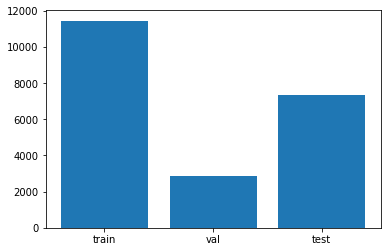

In [5]:
from utils import load_data
import matplotlib.pyplot as plt

# Lectura del dataset
path_dataset = f'{path_drive_compartido}TFG/SICAPv1/'
dataloaders, dataset_sizes = load_data(path_dataset)

names = list(dataset_sizes.keys())
values = list(dataset_sizes.values())

plt.bar(range(len(dataset_sizes)), values, tick_label=names)
plt.show()

## Carga de los modelos

En esta celda se van a cargar todos los datos almacenados del modelo. Es un diccionario de Python que contiene al modelo con sus pesos ya entrenados, junto con sus mejores marcas de entrenamiento y validación para que, en caso de que se quiera reentrenar, pueda hacerlo desde donde lo dejó la última vez que entrenó

In [6]:
from utils import load_model

path_modelos = f'{path_drive_compartido}TFG/modelos/'

modelos = ['VGG-cam', 'VGG-cam_pro', 
           'RESNET18-cam', 'RESNET18-cam_pro', 
           'MOBILENET-cam', 'MOBILENET-cam_pro', 
           'EFFICIENTNET-cam', 'EFFICIENTNET-cam_pro']


models_dic = {}
for modelo in modelos:
    # Lectura del modelo
    models_dic[f'{modelo}'] = load_model(path_modelos, 
                                         f'{modelo}', 
                                         device)



model_VGG-cam loaded
model_VGG-cam_pro loaded
model_RESNET18-cam loaded
model_RESNET18-cam_pro loaded
model_MOBILENET-cam loaded
model_MOBILENET-cam_pro loaded


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

model_EFFICIENTNET-cam loaded


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


model_EFFICIENTNET-cam_pro loaded



Para ver la arquitectura de la red basta con hacer un `print` del campo `'model'`del diccionario del modelo que se quiera. de la misma manera se pueden ver sus valores guardados en el campo `'best_values'`. La diferencia entre los modelos de _cam_ y _cam_pro_ está en el clasificador. Ya que la técnica de **CAM** solo se puede aplicar a redes que tengan como mucho una capa totalmente conectada después de las capas convolucionales, se pensó que los modelos de _cam_pro_ debían tener más capas para notar el avance que introdujo **Grad_CAM**, generalizando el método para redes con más de una capa totalmente conectada. De esta manera, los modelos de _cam_pro_ tienen tres capas totalmente conectadas en el clasificador.

In [6]:
print(models_dic['VGG-cam_pro']['best_values'])

{'loss': 0.011501810419901818, 'acc': 0.997204751921733, 'epochs': 31, 'gradcam-maximo_representativo': 0.019453363353386523, 'gradcam-umbral': 0.175, 'gradcampp-maximo_representativo': 10.176915740966797, 'gradcampp-umbral': 0.175, 'smoothgradcampp-maximo_representativo': 4.12266972064972, 'smoothgradcampp-umbral': 0.19999999999999998}


Valores como `loss`, `acc`, `epochs` hacen referencia a valores que van a permitir continuar con el entrenamiento en cualquier otro momento. Los valores de umbrales marcan el umbral óptimo que se encontró para cada técnica en la época de validación de umbral, que consiste en recorrer valores entre el 0 y el 1 para el umbral viendo cuál de ellos se comporta mejor para el conjunto completo de validación. Por último están los máximos representativos que su idea, que se ha dejado como trabajo futuro, era encontrar un valor máximo único para normalizar las imágenes y así umbralizar con mayor sentido.

In [7]:
print(models_dic['VGG-cam_pro']['model'])

CAM(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

## Búsqueda de umbrales

A la siguiente función hay que pasarle tanto el path donde se encuentran los modelos como donde se encuentran los datos. El parámetro `validation` hace referencia a qué conjunto de datos se va a usar: si está a `True` se usará el conjunto de validación, si está a `False` se usará el de Test. Por último el parámetro de `maximo_porcentaje_mascara` hace referencia al porcentaje (escrito con valores entre 0 y 1) de tejido patológico que se van a permitir tener en cuenta para calcular el umbral. Este parámetro nace de que el conjunto de datos está sesgado con imágenes que poseen un gran porcentaje de tejido cancerígeno, haciendo que los mejores umbrales sean cercanos a 0 y metiendo ruido en nuestro estudio de localización. Además, se incoporan los dos parámetros de Smooth Grad-CAM++, para poder regularlo a gusto personal.

Como propuesta de parámetros:
- `validation = True` ya que con el conjunto de Test le va a tomar mucho tiempo al programa para sacar los resultados.
- `maximo_porcentaje_mascara = 0.5` un 50% de tejido cancerígeno.
- `std_smoothgradcampp=0.25` ruido que se le va a aplicar a las imágenes en la técnica de Smooth Grad-CAM++. Es un valor que funciona bien. En cualquier caso valores mayores de 1 darán resultados malos. 
- `n_smoothgradcampp=5` número de imágenes con ruido generadas por Smooth Grad-CAM++. Es un valor que funciona bien. De este parámetro va a depender mucho el tiempo de ejecución. El valor usado en el estudio realmente es 10, pero los resultados no distan demasiado y tarda mucho más. Si se ve que la ejecución es muy larga ponerlo a 2. 


DEVICE:  cuda:0
Clases:  ['Benign', 'Pathological']
Train image size: 11454
Validation image size: 2862
Test image size: 7336
Dataset loaded.

model_vgg-cam loaded
técnica:  cam


C:\Users\pedro\Documents\TFG\TFG\src\CAM\cam_abstract.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2318.)
  activations_final = relu(((parameters[class_i]*activations.T).T).sum(axis=0)).to(device)


Número de imágenes tenidas en cuenta:  160
model_vgg-cam_pro loaded
técnica:  gradcam
Número de imágenes tenidas en cuenta:  160
técnica:  gradcampp
Número de imágenes tenidas en cuenta:  160
técnica:  smoothgradcampp
Número de imágenes tenidas en cuenta:  160


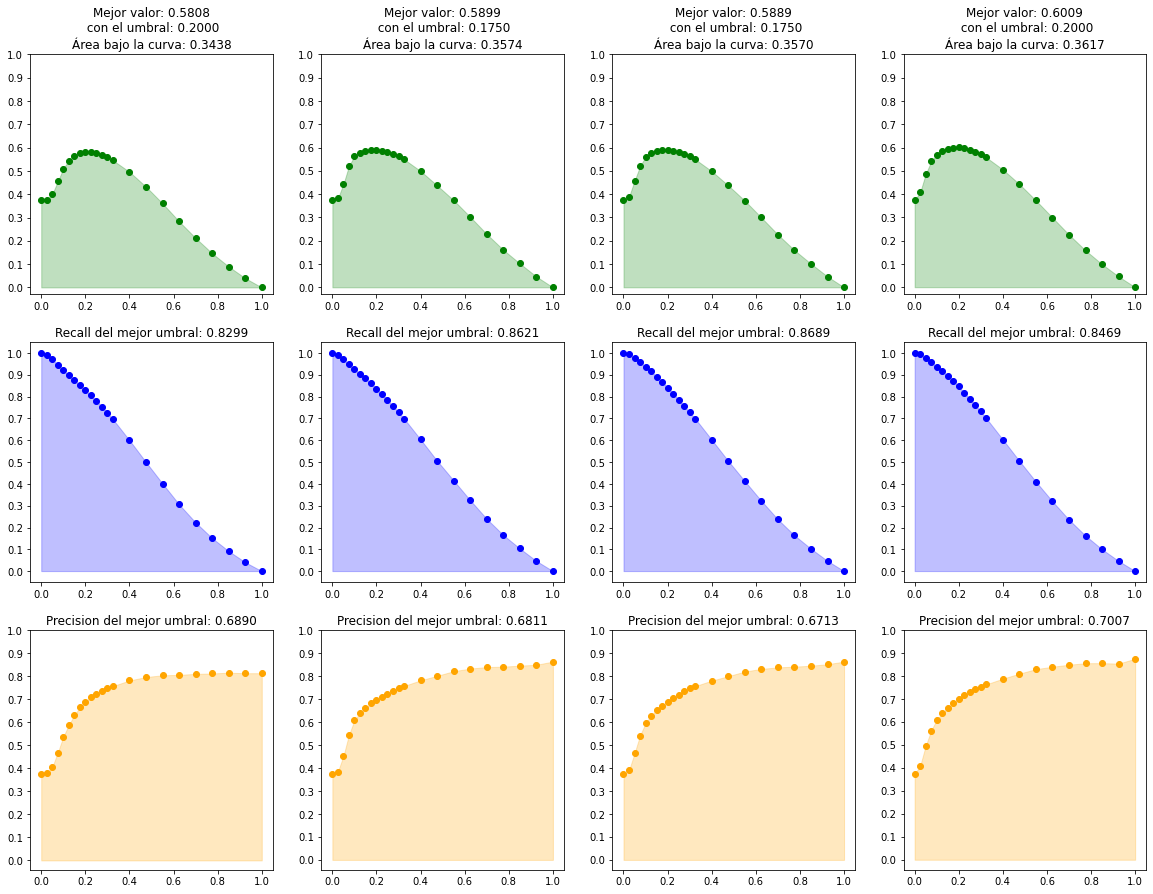

model_resnet18-cam loaded
técnica:  cam
Número de imágenes tenidas en cuenta:  160
model_resnet18-cam_pro loaded
técnica:  gradcam
Número de imágenes tenidas en cuenta:  160
técnica:  gradcampp
Número de imágenes tenidas en cuenta:  160
técnica:  smoothgradcampp
Número de imágenes tenidas en cuenta:  160


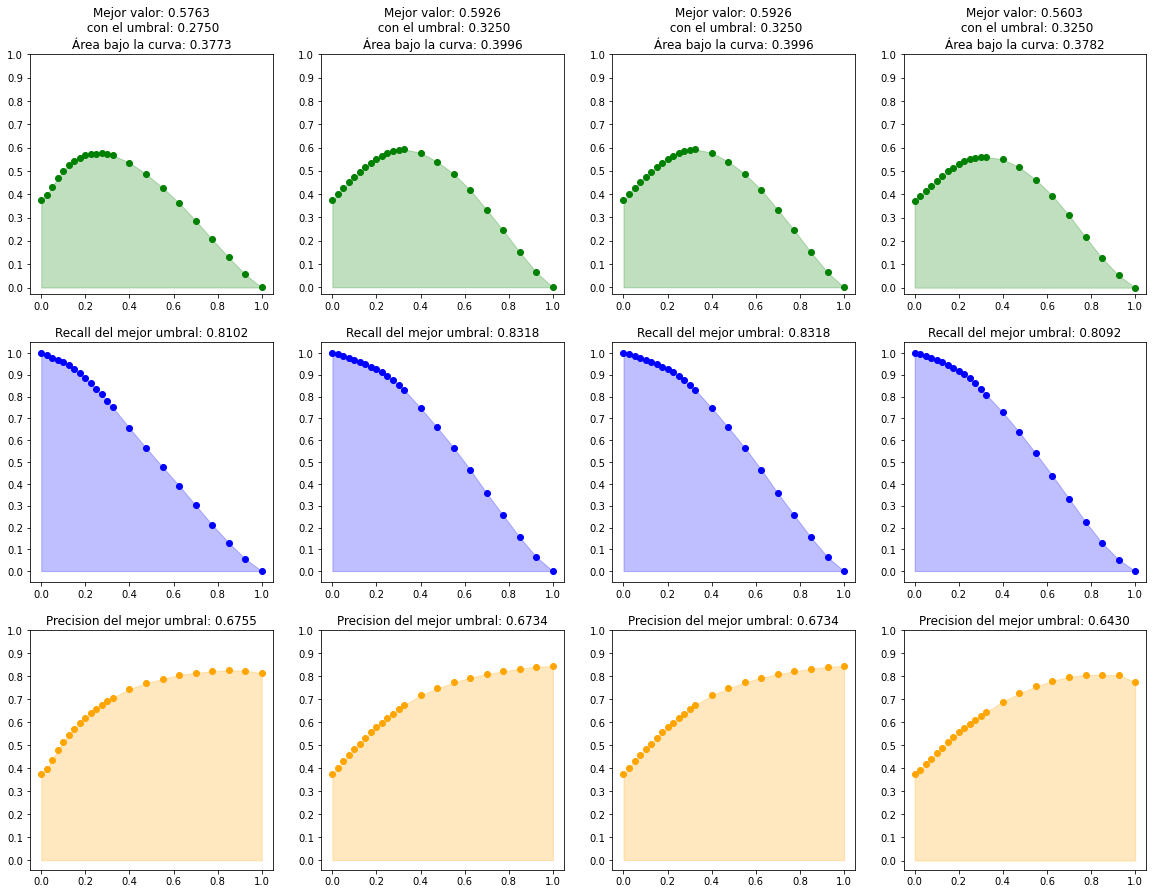

model_mobilenet-cam loaded
técnica:  cam
Número de imágenes tenidas en cuenta:  160
model_mobilenet-cam_pro loaded
técnica:  gradcam
Número de imágenes tenidas en cuenta:  160
técnica:  gradcampp
Número de imágenes tenidas en cuenta:  160
técnica:  smoothgradcampp
Número de imágenes tenidas en cuenta:  160


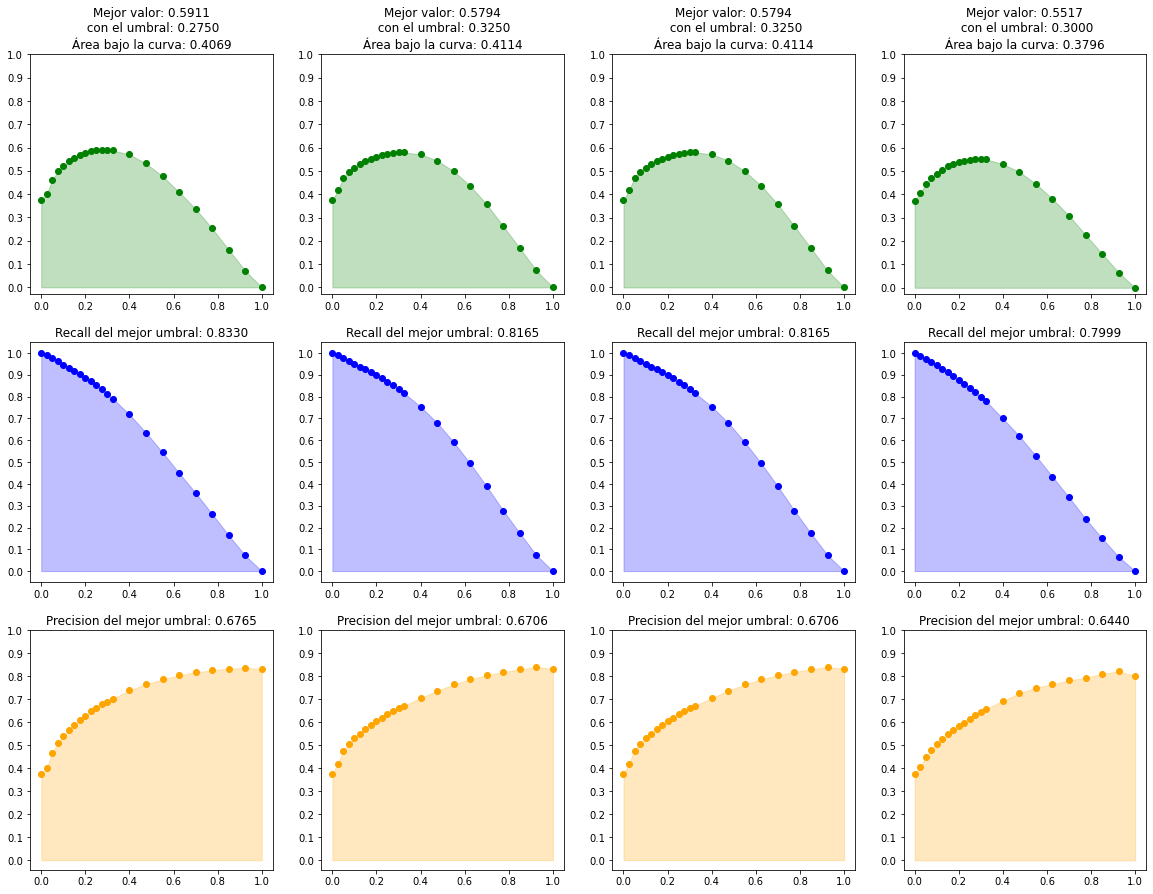

Using cache found in C:\Users\pedro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


model_efficientnet-cam loaded
técnica:  cam
Número de imágenes tenidas en cuenta:  160


Using cache found in C:\Users\pedro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


model_efficientnet-cam_pro loaded
técnica:  gradcam
Número de imágenes tenidas en cuenta:  160
técnica:  gradcampp
Número de imágenes tenidas en cuenta:  160
técnica:  smoothgradcampp
Número de imágenes tenidas en cuenta:  160


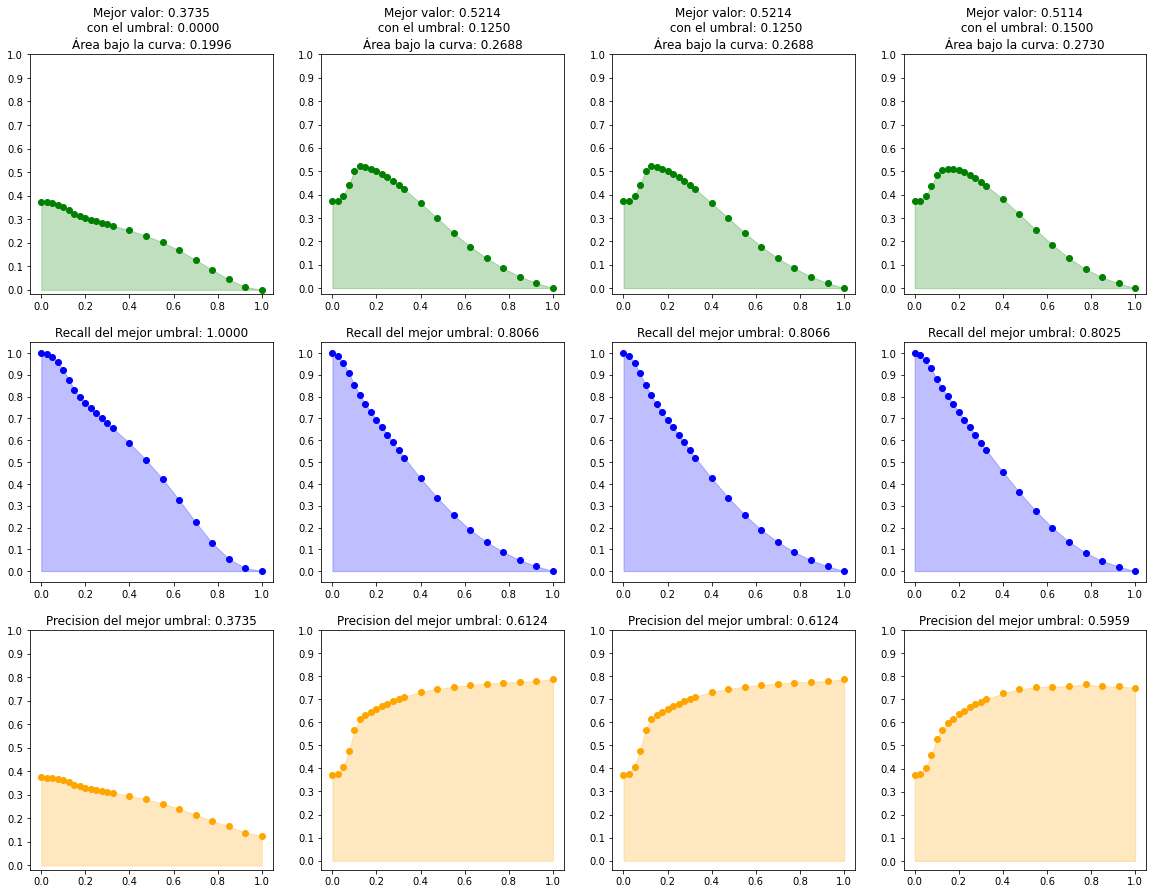

In [ ]:
from utils import run_umbrales_iou
"""
CUIDADO. La ejecución de esta celda en Google Colab puede llevar mucho tiempo (horas). 
Si se quiere ejecutar se recomienda hacerlo desde un entorno local siempre y cuando
se disponga de buen hardware.
"""
run_umbrales_iou(path_modelos,
                 path_dataset, 
                 validation=True, 
                 maximo_porcentaje_mascara=0.5,  
                 std_smoothgradcampp=0.25,  
                 n_smoothgradcampp=2,
                 device=device)

Media de porcentajes 0.65525913
Número de imágenes con menos de 50.0% de tejido patológico:  1084
Frecuencias absolutas:  [  0.   0.   0. 445. 419. 437. 414. 359. 265. 314. 669.]
Acumulación de frecuencias:  [   0.    0.    0.  445.  864. 1301. 1715. 2074. 2339. 2653. 3322.]


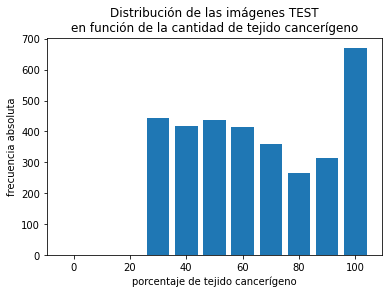

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from utils import prepare_mask
"""
Tarda unos 25 minutos ejecutando con GPU en Google Colab
"""

contador = np.array([0. for i in range(11)])
acumulacion = np.array([0. for i in range(11)])
porcentaje = 0.5
imagenes_debajo_de_porcentaje = 0
porcentajes = []
for im, mask_, label in dataloaders['test']:
    if label[0].item()!=1:
        continue
    
    # Como mask_ es una imagen .jpg a la que se le han aplicado transformaciones, con
    # prepare_mask se consigue discretizar la máscara dejándola con únicamente los
    # valores 0 y 1
    mask = prepare_mask(mask_) 
    media = mask.mean()/mask.max()
    posicion = int(media*10+0.5)
    
    porcentajes.append(media)
    contador[posicion]+=1
    acumulacion[posicion:]+=1
    
    if media<=porcentaje:
        imagenes_debajo_de_porcentaje+=1
    
print("Media de porcentajes", np.array(porcentajes).mean())
print(f"Número de imágenes con menos de {porcentaje*100}% de tejido patológico: ",imagenes_debajo_de_porcentaje)
print("Frecuencias absolutas: ", contador)
print("Acumulación de frecuencias: ", acumulacion)
    
plt.bar(np.array(range(11))*10,contador, width=8)
plt.ylabel('frecuencia absoluta')
plt.xlabel('porcentaje de tejido cancerígeno')
plt.title('Distribución de las imágenes TEST\nen función de la cantidad de tejido cancerígeno')
plt.show()


## Ejecución de ejemplos

In [7]:
from CAM.utils_cam import plot_grid

def plot_examples(path_modelos, dataloader, n_examples,
                  cam=False, gradcam=False, gradcampp=False, smoothgradcampp=False, # Technics
                  vgg=False, resnet=False, mobilenet=False, efficientnet=False):     # Nets)):
    
    iter_dataloader = iter(dataloaders['test'])
    for i in range(n_examples):
        # Cogemos la activación de las capas
        x, mask, act_classes=next(iter_dataloader)

        
        while act_classes[0]!=1:
            x, mask, act_classes=next(iter_dataloader)

        x=x.to(device)
        act_classes=act_classes.to(device)

        
        plot_grid(x, mask, act_classes,                                         # Data
                  n_noise=10, std=0.25,                                         # Hyperparameters for Smooth Grad-CAM++
                  cam=cam, gradcam=gradcam, gradcampp=gradcampp, smoothgradcampp=smoothgradcampp, # Technics
                  vgg=vgg, resnet=resnet, mobilenet=mobilenet, efficientnet=efficientnet,         # Nets
                  device=device,
                  path_modelos=path_modelos)

        print('='*50)
        
dataloader = dataloaders['test']
n_examples = 1

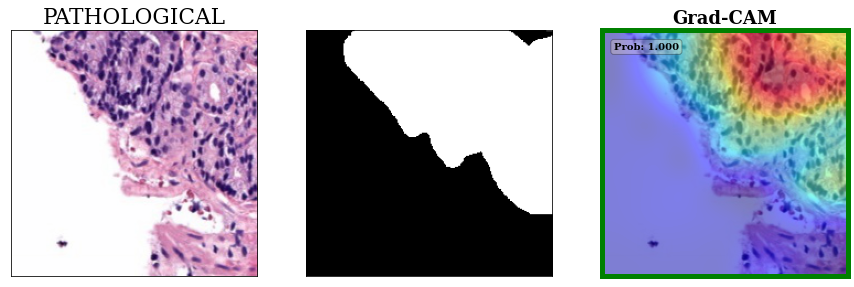

In [8]:
# Mostramos solo una red con una técnica
plot_examples(path_modelos, dataloader, n_examples, gradcam=True, vgg=True)

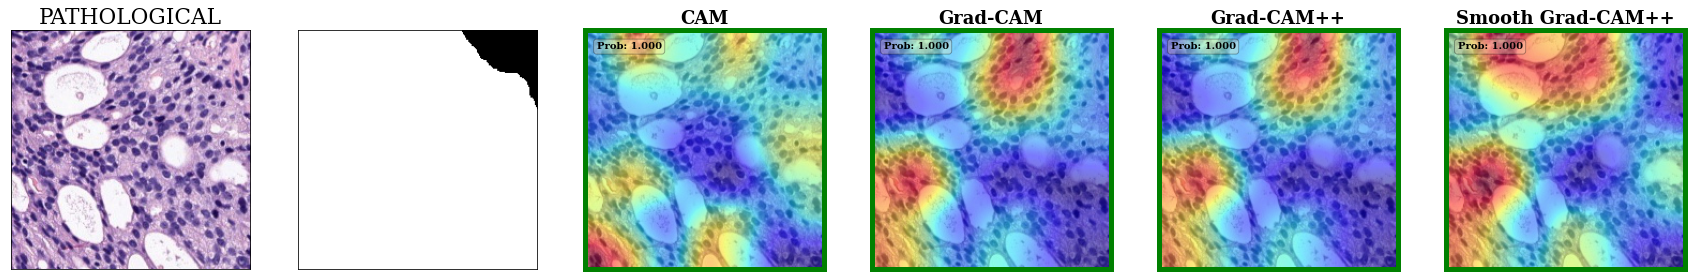

In [9]:
# Mostramos una red con todas las técnicas
plot_examples(path_modelos, dataloader, n_examples,
              cam=True, gradcam=True, gradcampp=True, smoothgradcampp=True,
              vgg=True)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


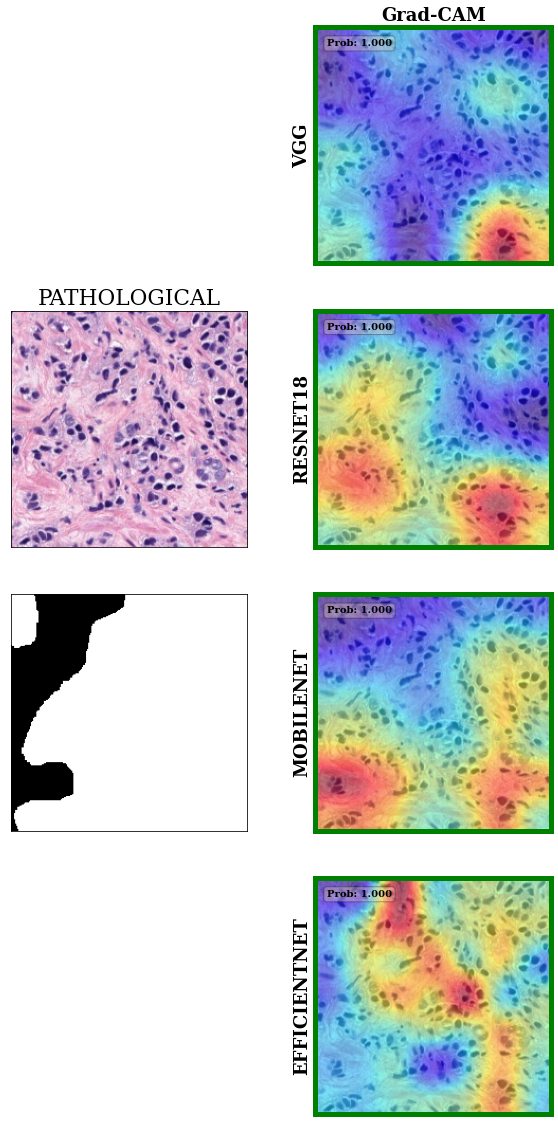

In [11]:
# Mostramos una técnica con todos los modelos
plot_examples(path_modelos, dataloader, n_examples,
              gradcam=True, # Technics
              vgg=True, resnet=True, mobilenet=True, efficientnet=True)     # Nets)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


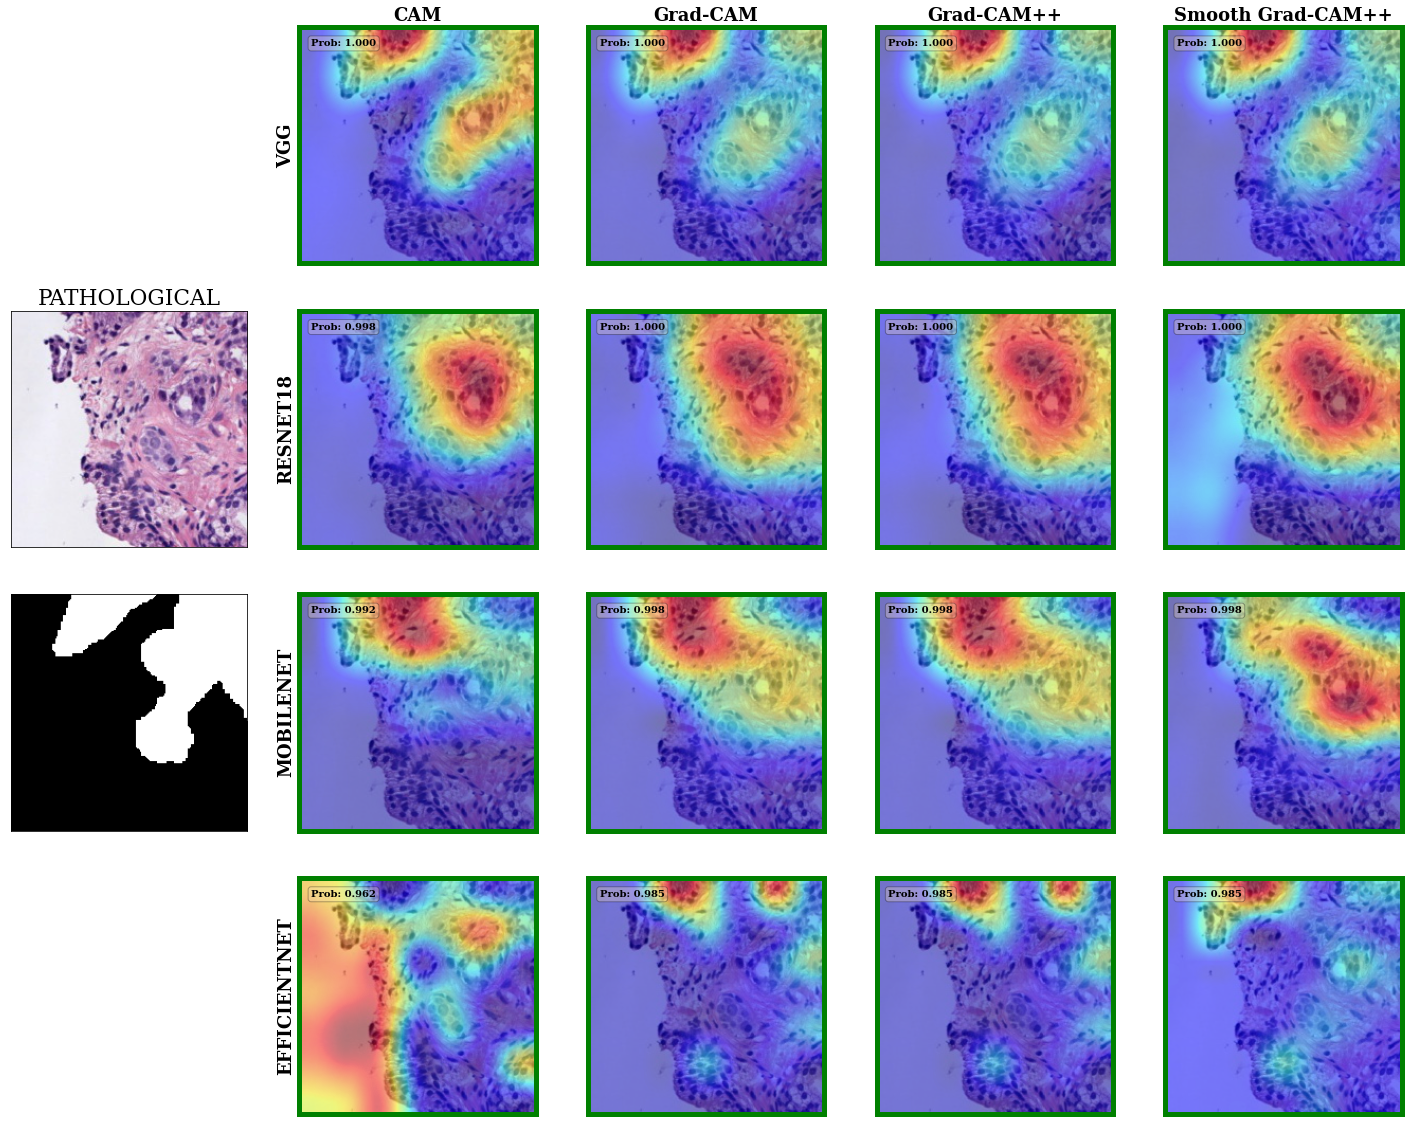

In [12]:
# Mostramos una red con todas las técnicas
plot_examples(path_modelos, dataloader, n_examples,
              cam=True, gradcam=True, gradcampp=True, smoothgradcampp=True,
              vgg=True, resnet=True, mobilenet=True, efficientnet=True)     # Nets)

## Test

En caso de que se tenga curiosidad sobre el proceso de test, habría que ejecutar la siguiente celda. El parámetro de `maximo_porcentaje_mascara` tiene que ver con el porcentaje de tejido cancerígeno (en imágenes patológicas) o tejido en general (en imágenes benignas) que deben de tener las imágenes que se tienen en cuenta. Por si se tiene curiosidad de cómo funcionan los modelos dentro del subconjunto de datos que se ha cogido para localizar.

In [ ]:
from utils import test_cam_models
test_cam_models(path_modelos, path_dataset, maximo_porcentaje_mascara=0.5)

DEVICE:  cuda:0
Clases:  ['Benign', 'Pathological']
Train image size: 11454
Validation image size: 2862
Test image size: 7336
Dataset loaded.

model_vgg-cam loaded
[999] loss: 0.062
[5999] loss: 0.051
[6999] loss: 0.049
TP: 1023,	 FN: 61
FP: 13,	 TN: 592

Accuracy: 0.9561870929544108
Recall: 0.9437269372693727
Precision: 0.9874517374517374
F1-Score: 0.9650943396226416
TEST
 Loss: 0.0511 Acc: 0.2201
Testing complete in 0m 21s
model_vgg-cam_pro loaded
[999] loss: 0.026
[6499] loss: 0.032
TP: 1044,	 FN: 40
FP: 7,	 TN: 598

Accuracy: 0.9721728833629366
Recall: 0.9630996309963099
Precision: 0.9933396764985728
F1-Score: 0.9779859484777518
TEST
 Loss: 0.0288 Acc: 0.2238
Testing complete in 0m 21s
model_resnet18-cam loaded
[1499] loss: 0.077
[1999] loss: 0.075
[2499] loss: 0.074
[2999] loss: 0.083
[3499] loss: 0.079
[4499] loss: 0.079
[5499] loss: 0.079
[6999] loss: 0.069
TP: 991,	 FN: 93
FP: 11,	 TN: 594

Accuracy: 0.9384251036116045
Recall: 0.9142066420664207
Precision: 0.9890219560878244
F1

Using cache found in C:\Users\pedro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


[2999] loss: 0.065
[3499] loss: 0.061
[5999] loss: 0.066
[6499] loss: 0.067
TP: 965,	 FN: 119
FP: 25,	 TN: 580

Accuracy: 0.9147424511545293
Recall: 0.8902214022140221
Precision: 0.9747474747474747
F1-Score: 0.9305689488910318
TEST
 Loss: 0.0664 Acc: 0.2106
Testing complete in 0m 34s
model_efficientnet-cam_pro loaded


Using cache found in C:\Users\pedro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


[999] loss: 0.082
[1499] loss: 0.089
[2499] loss: 0.089
[2999] loss: 0.103
[5499] loss: 0.101
[6999] loss: 0.107
TP: 972,	 FN: 112
FP: 32,	 TN: 573

Accuracy: 0.9147424511545293
Recall: 0.8966789667896679
Precision: 0.9681274900398407
F1-Score: 0.9310344827586207
TEST
 Loss: 0.1046 Acc: 0.2106
Testing complete in 0m 35s
